## Problem Statement

Credit Card Lead Prediction

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.

The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 

In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.

Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

#### Import the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#### Inspect the data

In [2]:
train = pd.read_csv("train_s3TEQDk.csv")
test = pd.read_csv("test_mSzZ8RL.csv")

In [3]:
train.shape, test.shape

((245725, 11), (105312, 10))

   ###### -> We have 245725 rows and 11 columns in Train set whereas Test set has 105312 rows and 10 columns.

In [4]:
train.nunique(), test.nunique()

(ID                     245725
 Gender                      2
 Age                        63
 Region_Code                35
 Occupation                  4
 Channel_Code                4
 Vintage                    66
 Credit_Product              2
 Avg_Account_Balance    135292
 Is_Active                   2
 Is_Lead                     2
 dtype: int64,
 ID                     105312
 Gender                      2
 Age                        62
 Region_Code                35
 Occupation                  4
 Channel_Code                4
 Vintage                    66
 Credit_Product              2
 Avg_Account_Balance     78315
 Is_Active                   2
 dtype: int64)

In [5]:
#ratio of null values
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [6]:
train.isnull().sum()/train.shape[0] *100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.934073
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

In [7]:
test.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

In [8]:
test.isnull().sum()/test.shape[0] *100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.890383
Avg_Account_Balance     0.000000
Is_Active               0.000000
dtype: float64

######    -> We have 12% of missing values in Credit_Product column.

In [9]:
#categorical features
categorical = train.select_dtypes(include =[np.object])
print("Categorical Features in Train Set:",categorical.shape[1])

#numerical features
numerical= train.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Train Set:",numerical.shape[1])

Categorical Features in Train Set: 7
Numerical Features in Train Set: 4


In [10]:
#categorical features
categorical = test.select_dtypes(include =[np.object])
print("Categorical Features in Test Set:",categorical.shape[1])

#numerical features
numerical= test.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Test Set:",numerical.shape[1])

Categorical Features in Test Set: 7
Numerical Features in Test Set: 3


In [11]:
train.columns.difference(test.columns)

Index(['Is_Lead'], dtype='object')

In [12]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [13]:
 test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


#### Clean the data

In [14]:
train["source"] = "train"
test["source"] = "test"

data = pd.concat([train,test])

In [15]:
data.shape

(351037, 12)

In [16]:
data.drop_duplicates(inplace=True)

In [17]:
data.shape

(351037, 12)

In [18]:
data['Credit_Product'].isnull().sum(), data['Credit_Product'].value_counts()

(41847,
 No     205965
 Yes    103225
 Name: Credit_Product, dtype: int64)

###### -> Since the Credit_Product is a categorical column, imputing the missing values by "Yes"

In [19]:
#data['Credit_Product'] = data['Credit_Product'].fillna(data['Credit_Product'].mode()[0])
data['Credit_Product'] = data['Credit_Product'].fillna("Yes")

In [20]:
data['Credit_Product'].isnull().sum(), data['Credit_Product'].value_counts()

(0,
 No     205965
 Yes    145072
 Name: Credit_Product, dtype: int64)

In [21]:
data.isnull().sum()

ID                          0
Gender                      0
Age                         0
Region_Code                 0
Occupation                  0
Channel_Code                0
Vintage                     0
Credit_Product              0
Avg_Account_Balance         0
Is_Active                   0
Is_Lead                105312
source                      0
dtype: int64

#### EDA

In [22]:
data.nunique()

ID                     351037
Gender                      2
Age                        63
Region_Code                35
Occupation                  4
Channel_Code                4
Vintage                    66
Credit_Product              2
Avg_Account_Balance    162137
Is_Active                   2
Is_Lead                     2
source                      2
dtype: int64

In [23]:
data["Gender"].value_counts()

Male      191902
Female    159135
Name: Gender, dtype: int64

In [24]:
data["Occupation"].value_counts()

Self_Employed    144078
Salaried         102912
Other            100304
Entrepreneur       3743
Name: Occupation, dtype: int64

In [25]:
data["Channel_Code"].value_counts()

X1    148202
X3     97981
X2     96902
X4      7952
Name: Channel_Code, dtype: int64

In [26]:
data["Credit_Product"].value_counts()

No     205965
Yes    145072
Name: Credit_Product, dtype: int64

In [27]:
data["Is_Active"].value_counts()

No     214087
Yes    136950
Name: Is_Active, dtype: int64

In [28]:
data["Is_Lead"].value_counts()

0.0    187437
1.0     58288
Name: Is_Lead, dtype: int64

In [29]:
data.set_index('ID',inplace=True)

<AxesSubplot:xlabel='Gender', ylabel='count'>

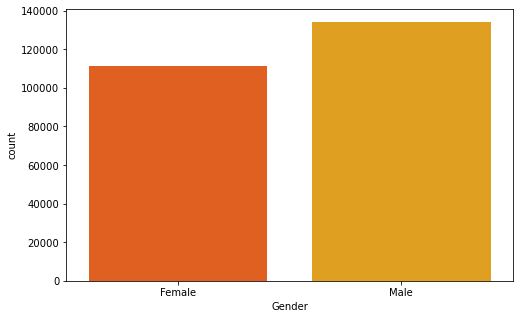

In [30]:
plt.figure(figsize=(8,5))
sns.countplot('Gender',data=train,palette='autumn')

###### -> Male customers are more than the Female customers

<AxesSubplot:ylabel='Frequency'>

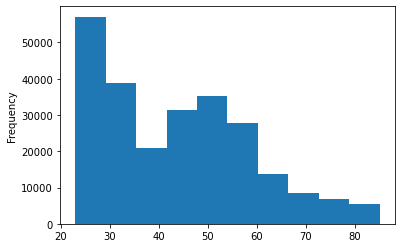

In [31]:
train["Age"].plot(kind="hist")

###### -> No customers below the age 23 and above the age 85

In [32]:
train["Age"].describe()

count    245725.000000
mean         43.856307
std          14.828672
min          23.000000
25%          30.000000
50%          43.000000
75%          54.000000
max          85.000000
Name: Age, dtype: float64

<AxesSubplot:xlabel='Region_Code', ylabel='count'>

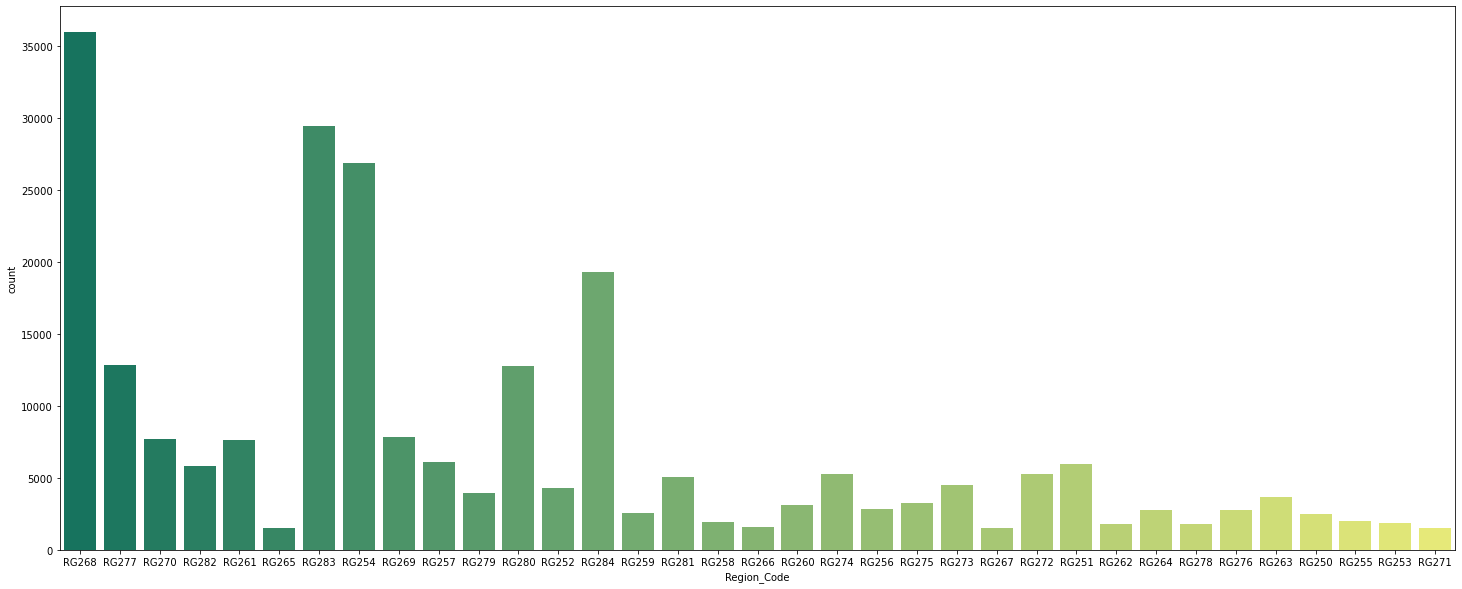

In [33]:
plt.figure(figsize=(25,10))
sns.countplot('Region_Code',data=train,palette='summer')

###### -> Customers from the region RG268 are high in numbers

<AxesSubplot:xlabel='Occupation', ylabel='count'>

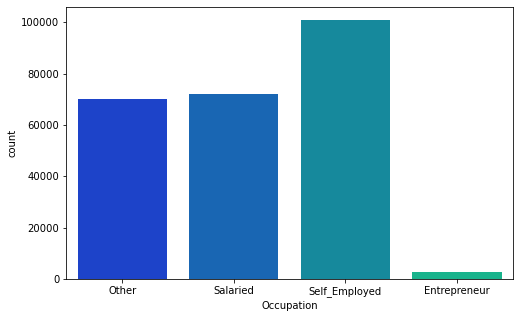

In [34]:
plt.figure(figsize=(8,5))
sns.countplot('Occupation',data=train,palette='winter')

###### -> Self employed Customers are high and Entrepreneur are the lowest

<AxesSubplot:xlabel='Channel_Code', ylabel='count'>

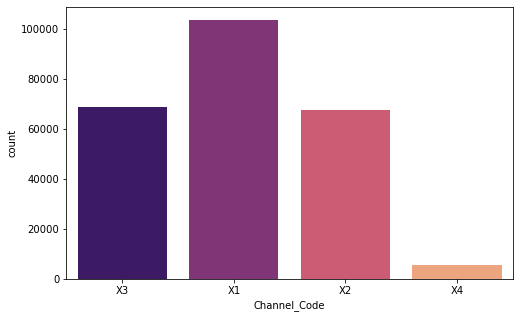

In [35]:
plt.figure(figsize=(8,5))
sns.countplot('Channel_Code',data=train,palette='magma')

###### -> X1 Channel has most customers and X4 has the lowest

<AxesSubplot:ylabel='Frequency'>

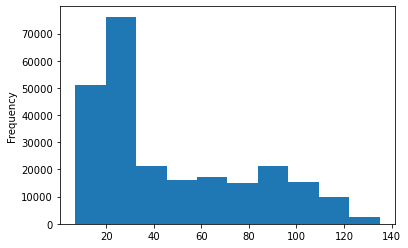

In [36]:
train["Vintage"].plot(kind="hist")

In [37]:
train["Vintage"].describe()

count    245725.000000
mean         46.959141
std          32.353136
min           7.000000
25%          20.000000
50%          32.000000
75%          73.000000
max         135.000000
Name: Vintage, dtype: float64

###### -> These customers are with us from minimum 6 months to nearly 10 years
######     Customers with us are found more in the range of <3 years  

<AxesSubplot:xlabel='Credit_Product', ylabel='count'>

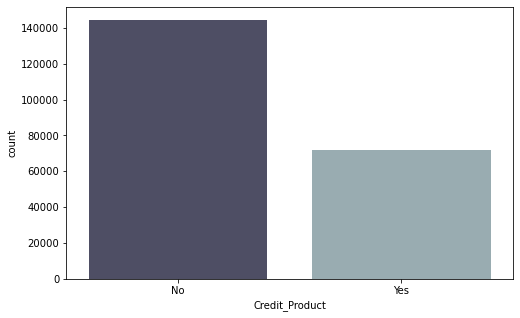

In [38]:
plt.figure(figsize=(8,5))
sns.countplot('Credit_Product',data=train,palette='bone')

###### -> Customers having no credits are more

In [39]:
train["Avg_Account_Balance"].describe()

count    2.457250e+05
mean     1.128403e+06
std      8.529364e+05
min      2.079000e+04
25%      6.043100e+05
50%      8.946010e+05
75%      1.366666e+06
max      1.035201e+07
Name: Avg_Account_Balance, dtype: float64

<AxesSubplot:ylabel='Frequency'>

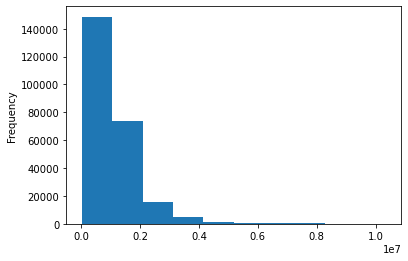

In [40]:
train["Avg_Account_Balance"].plot(kind='hist')

###### -> Customers under  2Million Avg Availalble Balance constitute the most

<AxesSubplot:xlabel='Is_Active', ylabel='count'>

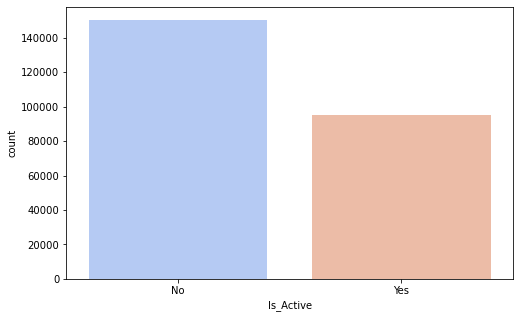

In [41]:
plt.figure(figsize=(8,5))
sns.countplot('Is_Active',data=train,palette='coolwarm')

###### -> More Customers are inactive 

<AxesSubplot:xlabel='Is_Lead', ylabel='count'>

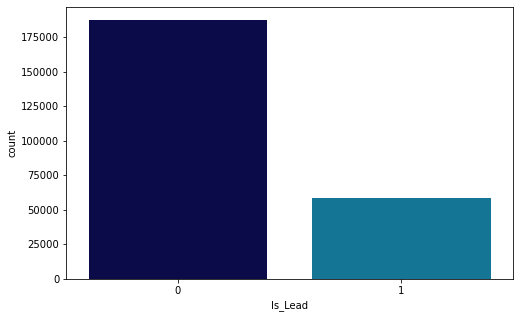

In [42]:
plt.figure(figsize=(8,5))
sns.countplot('Is_Lead',data=train,palette='ocean')

###### -> Dataset is skewed towards Not interested Customers

In [43]:
data_b4_fe = data.copy()

In [44]:
data_b4_fe.shape, data.shape

((351037, 11), (351037, 11))

In [45]:
#####data = data_b4_fe.copy()

In [46]:
data["Gender"] = np.where(data["Gender"]=="Male",1,0)

In [47]:
data["Gender"].value_counts()

1    191902
0    159135
Name: Gender, dtype: int64

In [48]:
data["Occupation"].replace({"Other":0,"Salaried":1,"Self_Employed":2,"Entrepreneur":3},inplace=True)

In [49]:
data["Occupation"].value_counts()

2    144078
1    102912
0    100304
3      3743
Name: Occupation, dtype: int64

In [50]:
data["Occupation"].value_counts()

2    144078
1    102912
0    100304
3      3743
Name: Occupation, dtype: int64

In [51]:
data["Channel_Code"].value_counts()

X1    148202
X3     97981
X2     96902
X4      7952
Name: Channel_Code, dtype: int64

In [52]:
data["Channel_Code"].replace({"X1":1,"X2":2,"X3":3,"X4":4},inplace=True)

In [53]:
data["Channel_Code"].value_counts()

1    148202
3     97981
2     96902
4      7952
Name: Channel_Code, dtype: int64

In [54]:
data["Credit_Product"].value_counts()

No     205965
Yes    145072
Name: Credit_Product, dtype: int64

In [55]:
data["Credit_Product"] = np.where(data["Credit_Product"]=="Yes",1,0)

In [56]:
data["Credit_Product"].value_counts()

0    205965
1    145072
Name: Credit_Product, dtype: int64

In [57]:
data["Is_Active"].value_counts()

No     214087
Yes    136950
Name: Is_Active, dtype: int64

In [58]:
data["Is_Active"] = np.where(data["Is_Active"]=="Yes",1,0)

In [59]:
data["Is_Active"].value_counts()

0    214087
1    136950
Name: Is_Active, dtype: int64

In [60]:
data["Region_Code"].unique(), data["Region_Code"].nunique()#, data["Region_Code"].value_counts()

(array(['RG268', 'RG277', 'RG270', 'RG282', 'RG261', 'RG265', 'RG283',
        'RG254', 'RG269', 'RG257', 'RG279', 'RG280', 'RG252', 'RG284',
        'RG259', 'RG281', 'RG258', 'RG266', 'RG260', 'RG274', 'RG256',
        'RG275', 'RG273', 'RG267', 'RG272', 'RG251', 'RG262', 'RG264',
        'RG278', 'RG276', 'RG263', 'RG250', 'RG255', 'RG253', 'RG271'],
       dtype=object),
 35)

In [61]:
#data["Region_Code"].apply(lambda x: x.split()[1])
data["Region_Code"] = data["Region_Code"].str.strip('RG').astype('int64')

In [62]:
data["Region_Code"].unique(), data["Region_Code"].nunique()#, data["Region_Code"].value_counts()

(array([268, 277, 270, 282, 261, 265, 283, 254, 269, 257, 279, 280, 252,
        284, 259, 281, 258, 266, 260, 274, 256, 275, 273, 267, 272, 251,
        262, 264, 278, 276, 263, 250, 255, 253, 271], dtype=int64),
 35)

In [63]:
data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,source
ID,,,,,,,,,,,
NNVBBKZB,0,73,268,0,3,43,0,1045696,0,0.0,train
IDD62UNG,0,30,277,1,1,32,0,581988,0,0.0,train
HD3DSEMC,0,56,268,2,3,26,0,1484315,1,0.0,train
BF3NC7KV,1,34,270,1,1,19,0,470454,0,0.0,train
TEASRWXV,0,30,282,1,1,33,0,886787,0,0.0,train


In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

ind_X = data.select_dtypes(include=np.number).drop(columns=['Is_Lead'])
vif_data = pd.DataFrame()
vif_data['feature'] = ind_X.columns
vif_data['VIF'] = [variance_inflation_factor(ind_X.values,i) for i in range(len(ind_X.columns))]
print(vif_data)

               feature        VIF
0               Gender   2.277233
1                  Age  21.291408
2          Region_Code  14.942227
3           Occupation   3.199088
4         Channel_Code  10.618664
5              Vintage   5.638599
6       Credit_Product   1.956545
7  Avg_Account_Balance   2.841321
8            Is_Active   1.830676


In [65]:
categorical_vars = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
for i in categorical_vars:
    print(train[train['Is_Lead']==1].groupby(i)['Is_Lead'].value_counts())#.nlargest(8))
    print("\n")

Gender  Is_Lead
Female  1          22705
Male    1          35583
Name: Is_Lead, dtype: int64


Region_Code  Is_Lead
RG250        1            393
RG251        1           1381
RG252        1            592
RG253        1            481
RG254        1           5713
RG255        1            469
RG256        1            401
RG257        1           1170
RG258        1            430
RG259        1            501
RG260        1            594
RG261        1           1282
RG262        1            323
RG263        1            818
RG264        1            383
RG265        1            400
RG266        1            220
RG267        1            223
RG268        1          10773
RG269        1           1743
RG270        1           1114
RG271        1            261
RG272        1           1155
RG273        1           1069
RG274        1            872
RG275        1            543
RG276        1            768
RG277        1           2975
RG278        1            400
RG279        

In [66]:
data_cp2 = data.copy()
data_cp2.shape

(351037, 11)

In [67]:
train_orig = train.copy()
test_orig = test.copy()

In [68]:
data.corr()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
Gender,1.000000,0.151621,0.003460,0.040153,0.150476,0.146208,0.078549,0.023488,0.065665,0.072068
Age,0.151621,1.000000,0.118347,-0.116001,0.604006,0.628558,0.245751,0.142563,0.219391,0.230814
Region_Code,0.003460,0.118347,1.000000,0.029354,0.104148,0.118954,0.078353,0.075311,0.059553,0.062501
Occupation,0.040153,-0.116001,0.029354,1.000000,0.158803,0.065207,0.078486,-0.021505,0.083039,0.063513
Channel_Code,0.150476,0.604006,0.104148,0.158803,1.000000,0.536948,0.302118,0.098654,0.250203,0.261211
Vintage,0.146208,0.628558,0.118954,0.065207,0.536948,1.000000,0.236266,0.166611,0.210762,0.279642
Credit_Product,0.078549,0.245751,0.078353,0.078486,0.302118,0.236266,1.000000,0.068125,-0.060379,0.459025
Avg_Account_Balance,0.023488,0.142563,0.075311,-0.021505,0.098654,0.166611,0.068125,1.000000,0.075905,0.053370
Is_Active,0.065665,0.219391,0.059553,0.083039,0.250203,0.210762,-0.060379,0.075905,1.000000,0.085723
Is_Lead,0.072068,0.230814,0.062501,0.063513,0.261211,0.279642,0.459025,0.053370,0.085723,1.000000


In [69]:
train = data[data["source"]=="train"]
test = data[data["source"]=="test"]

del train["source"]
del test["source"]
del test["Is_Lead"]
train_orig.shape, test_orig.shape, train.shape, test.shape, 

((245725, 12), (105312, 11), (245725, 10), (105312, 9))

In [70]:
cc=[]
#cc=['Age','Region_Code','Vintage','Avg_Account_Balance']
#cc=['Region_Code']
train.drop(cc, axis=1, inplace=True)
test.drop(cc, axis=1, inplace=True)
train_orig.shape, test_orig.shape, train.shape, test.shape, 

((245725, 12), (105312, 11), (245725, 10), (105312, 9))

In [71]:
train_b4_ssc = train.copy()
test_b4_ssc = test.copy()

In [72]:
train['Is_Lead'].value_counts()

0.0    187437
1.0     58288
Name: Is_Lead, dtype: int64

In [73]:
Leads = train[train['Is_Lead']==1]
Leads.shape

(58288, 10)

In [74]:
Non_leads = train[train['Is_Lead']==0]
Non_leads.shape

(187437, 10)

In [75]:
selected_Non_leads = Non_leads.sample(n=Leads.shape[0], random_state=22)
train_undersample= pd.concat([Leads,selected_Non_leads],axis=0)
train_undersample.shape

(116576, 10)

In [76]:
train_undersample[train_undersample==1].shape,train_undersample[train_undersample==0].shape

((116576, 10), (116576, 10))

In [77]:
train_undersample_y = train_undersample["Is_Lead"]
train_undersample_y.shape#, train_undersample_y.columns()

(116576,)

In [78]:
train.columns, train_undersample.columns

(Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
        'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Is_Lead'],
       dtype='object'),
 Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
        'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Is_Lead'],
       dtype='object'))

In [79]:
train = train_undersample.copy()

In [80]:
print(Non_leads.shape[0], Leads.shape[0], Non_leads.shape[0]-Leads.shape[0])
selected_Leads = Leads.sample(n=Non_leads.shape[0]-Leads.shape[0], random_state=22, replace=True)
selected_Leads.shape
train_oversample= pd.concat([Non_leads,selected_Leads],axis=0)
print(train_oversample.shape)
train_oversample[train_oversample==1].shape,train_oversample[train_oversample==0].shape

187437 58288 129149
(316586, 10)


((316586, 10), (316586, 10))

In [81]:
train_oversample_y = train_oversample["Is_Lead"]
print(train_oversample_y.shape)

(316586,)


In [82]:
train = train_oversample.copy()

In [83]:
from sklearn.preprocessing import StandardScaler

In [84]:
ssc_col_names = ['Age','Vintage','Avg_Account_Balance'] #,'Region_Code'
ssc_features = train[ssc_col_names]

scaler = StandardScaler().fit(ssc_features.values)
ssc_features = scaler.transform(ssc_features.values)

train[ssc_col_names] = ssc_features
#train_ssc.shape, test_ssc.shape, 
train.shape, test.shape

ssc_features = test[ssc_col_names]

scaler = StandardScaler().fit(ssc_features.values)
ssc_features = scaler.transform(ssc_features.values)

test[ssc_col_names] = ssc_features
train.shape, test.shape

((316586, 10), (105312, 9))

In [85]:
train.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
ID,,,,,,,,,,
NNVBBKZB,0,1.898172,268,0,3,-0.224482,0,-0.116348,0,0.0
IDD62UNG,0,-1.040223,277,1,1,-0.553120,0,-0.657169,0,0.0
HD3DSEMC,0,0.736481,268,2,3,-0.732377,0,0.395211,1,0.0
BF3NC7KV,1,-0.766884,270,1,1,-0.941510,0,-0.787251,0,0.0
TEASRWXV,0,-1.040223,282,1,1,-0.523243,0,-0.301683,0,0.0


In [86]:
test.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
ID,,,,,,,,,
VBENBARO,1,-0.999878,254,0,1,-0.676804,1,-0.452333,0
CCMEWNKY,1,-0.058563,268,0,2,0.066841,1,-0.240878,0
VK3KGA9M,1,-0.865404,270,1,1,-1.017641,0,-1.060037,0
TT8RPZVC,1,-0.999878,272,0,1,-0.428922,0,-0.307219,0
SHQZEYTZ,0,-0.999878,270,0,1,-0.862715,0,-0.550781,0


In [87]:
'''from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
ohe_cat_cols = ["Occupation", "Channel_Code"]
transformed_trdata = onehotencoder.fit_transform(train[ohe_cat_cols])
encoded_trdata = pd.DataFrame(transformed_trdata, index=train.index)
train = pd.concat([train, encoded_trdata], axis=1)
train.drop(columns=["Occupation", "Channel_Code"], inplace=True)
train.head()
'''

train_ohe = train.copy()
ohe_cat_cols = ["Occupation", "Channel_Code","Region_Code"]
for col in ohe_cat_cols:
    col_ohe = pd.get_dummies(train[col], prefix=col)
    train_ohe = pd.concat((train_ohe, col_ohe), axis=1).drop(col, axis=1)
train_ohe.head()
train = train_ohe.copy()
train.head()


,Gender,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_0,Occupation_1,Occupation_2,...,Region_Code_275,Region_Code_276,Region_Code_277,Region_Code_278,Region_Code_279,Region_Code_280,Region_Code_281,Region_Code_282,Region_Code_283,Region_Code_284
ID,,,,,,,,,,,,,,,,,,,,,
NNVBBKZB,0,1.898172,-0.224482,0,-0.116348,0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
IDD62UNG,0,-1.040223,-0.553120,0,-0.657169,0,0.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
HD3DSEMC,0,0.736481,-0.732377,0,0.395211,1,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
BF3NC7KV,1,-0.766884,-0.941510,0,-0.787251,0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
TEASRWXV,0,-1.040223,-0.523243,0,-0.301683,0,0.0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [88]:
test_ohe = test.copy()
ohe_cat_cols = ["Occupation", "Channel_Code","Region_Code"] 
for col in ohe_cat_cols:
    col_ohe = pd.get_dummies(test[col], prefix=col)
    test_ohe = pd.concat((test_ohe, col_ohe), axis=1).drop(col, axis=1)
test_ohe.head()
test = test_ohe.copy()
test.head()

,Gender,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Occupation_0,Occupation_1,Occupation_2,Occupation_3,...,Region_Code_275,Region_Code_276,Region_Code_277,Region_Code_278,Region_Code_279,Region_Code_280,Region_Code_281,Region_Code_282,Region_Code_283,Region_Code_284
ID,,,,,,,,,,,,,,,,,,,,,
VBENBARO,1,-0.999878,-0.676804,1,-0.452333,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCMEWNKY,1,-0.058563,0.066841,1,-0.240878,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VK3KGA9M,1,-0.865404,-1.017641,0,-1.060037,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
TT8RPZVC,1,-0.999878,-0.428922,0,-0.307219,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SHQZEYTZ,0,-0.999878,-0.862715,0,-0.550781,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

ind_X = train.select_dtypes(include=np.number).drop(columns=['Is_Lead'])
vif_data = pd.DataFrame()
vif_data['feature'] = ind_X.columns
vif_data['VIF'] = [variance_inflation_factor(ind_X.values,i) for i in range(len(ind_X.columns))]
print(vif_data)

                feature       VIF
0                Gender  1.042730
1                   Age  2.600377
2               Vintage  2.092963
3        Credit_Product  1.212915
4   Avg_Account_Balance  1.170785
5             Is_Active  1.124298
6          Occupation_0       inf
7          Occupation_1       inf
8          Occupation_2       inf
9          Occupation_3       inf
10       Channel_Code_1       inf
11       Channel_Code_2       inf
12       Channel_Code_3       inf
13       Channel_Code_4       inf
14      Region_Code_250       inf
15      Region_Code_251       inf
16      Region_Code_252       inf
17      Region_Code_253       inf
18      Region_Code_254       inf
19      Region_Code_255       inf
20      Region_Code_256       inf
21      Region_Code_257       inf
22      Region_Code_258       inf
23      Region_Code_259       inf
24      Region_Code_260       inf
25      Region_Code_261       inf
26      Region_Code_262       inf
27      Region_Code_263       inf
28      Region

##### Model Building

In [90]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316586 entries, NNVBBKZB to VXDJUR2O
Data columns (total 50 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               316586 non-null  int32  
 1   Age                  316586 non-null  float64
 2   Vintage              316586 non-null  float64
 3   Credit_Product       316586 non-null  int32  
 4   Avg_Account_Balance  316586 non-null  float64
 5   Is_Active            316586 non-null  int32  
 6   Is_Lead              316586 non-null  float64
 7   Occupation_0         316586 non-null  uint8  
 8   Occupation_1         316586 non-null  uint8  
 9   Occupation_2         316586 non-null  uint8  
 10  Occupation_3         316586 non-null  uint8  
 11  Channel_Code_1       316586 non-null  uint8  
 12  Channel_Code_2       316586 non-null  uint8  
 13  Channel_Code_3       316586 non-null  uint8  
 14  Channel_Code_4       316586 non-null  uint8  
 15  Region_Code_2

(None, None)

In [91]:
# Seperate Features and Target
y = train["Is_Lead"]
X = train.drop(columns = ["Is_Lead"], axis=1)


In [92]:
X.shape, y.shape

((316586, 49), (316586,))

In [93]:
# 20% data as validation set
train_X,valid_X,train_y,valid_y = train_test_split(X,y,test_size=0.2,random_state=22
                                                  ,stratify=train_oversample_y,shuffle=True)

In [94]:
#LogReg=LogisticRegression( C=1.0,max_iter = 100, penalty='l1', solver='saga',tol=0.0001)
#LogReg=LogisticRegression(max_iter=300,penalty='l1', solver= 'liblinear')

model = LogisticRegression(max_iter=10000)
#model = LogisticRegression(max_iter=300,penalty='l1', solver= 'liblinear')
#model = LogisticRegression( C=1.0,max_iter = 100, penalty='l1', solver='saga',tol=0.0001)
model.fit(train_X,train_y)

LogisticRegression(max_iter=10000)

In [95]:
model.coef_, model.intercept_

(array([[ 0.03603035,  0.14681645,  0.32893475,  2.21313982, -0.03242382,
          0.38399072, -0.71955529,  0.16378074, -0.6130249 ,  0.08910398,
         -0.90542872,  0.0418728 , -0.11283743, -0.10330211, -0.24461584,
          0.08814501, -0.0428335 , -0.06886027, -0.07576193, -0.02383397,
         -0.09961059,  0.10466748,  0.09195745, -0.09638361,  0.01953381,
         -0.12000994, -0.13468195,  0.1297458 , -0.14274832, -0.03250751,
         -0.14303354, -0.44635049,  0.04062731,  0.16769434,  0.04887951,
         -0.1678715 ,  0.02584284,  0.1214731 , -0.12172666, -0.20662098,
          0.07328123,  0.15216354, -0.16641309,  0.14637635,  0.08529154,
         -0.05518193, -0.02980614,  0.01997228,  0.02350471]]),
 array([-1.09565755]))

In [96]:
model.coef_[0]

array([ 0.03603035,  0.14681645,  0.32893475,  2.21313982, -0.03242382,
        0.38399072, -0.71955529,  0.16378074, -0.6130249 ,  0.08910398,
       -0.90542872,  0.0418728 , -0.11283743, -0.10330211, -0.24461584,
        0.08814501, -0.0428335 , -0.06886027, -0.07576193, -0.02383397,
       -0.09961059,  0.10466748,  0.09195745, -0.09638361,  0.01953381,
       -0.12000994, -0.13468195,  0.1297458 , -0.14274832, -0.03250751,
       -0.14303354, -0.44635049,  0.04062731,  0.16769434,  0.04887951,
       -0.1678715 ,  0.02584284,  0.1214731 , -0.12172666, -0.20662098,
        0.07328123,  0.15216354, -0.16641309,  0.14637635,  0.08529154,
       -0.05518193, -0.02980614,  0.01997228,  0.02350471])

In [97]:
features = train_X.columns
features


Index(['Gender', 'Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance',
       'Is_Active', 'Occupation_0', 'Occupation_1', 'Occupation_2',
       'Occupation_3', 'Channel_Code_1', 'Channel_Code_2', 'Channel_Code_3',
       'Channel_Code_4', 'Region_Code_250', 'Region_Code_251',
       'Region_Code_252', 'Region_Code_253', 'Region_Code_254',
       'Region_Code_255', 'Region_Code_256', 'Region_Code_257',
       'Region_Code_258', 'Region_Code_259', 'Region_Code_260',
       'Region_Code_261', 'Region_Code_262', 'Region_Code_263',
       'Region_Code_264', 'Region_Code_265', 'Region_Code_266',
       'Region_Code_267', 'Region_Code_268', 'Region_Code_269',
       'Region_Code_270', 'Region_Code_271', 'Region_Code_272',
       'Region_Code_273', 'Region_Code_274', 'Region_Code_275',
       'Region_Code_276', 'Region_Code_277', 'Region_Code_278',
       'Region_Code_279', 'Region_Code_280', 'Region_Code_281',
       'Region_Code_282', 'Region_Code_283', 'Region_Code_284'],
      dtype

In [98]:
cols = list(train_X.columns)
cols

['Gender',
 'Age',
 'Vintage',
 'Credit_Product',
 'Avg_Account_Balance',
 'Is_Active',
 'Occupation_0',
 'Occupation_1',
 'Occupation_2',
 'Occupation_3',
 'Channel_Code_1',
 'Channel_Code_2',
 'Channel_Code_3',
 'Channel_Code_4',
 'Region_Code_250',
 'Region_Code_251',
 'Region_Code_252',
 'Region_Code_253',
 'Region_Code_254',
 'Region_Code_255',
 'Region_Code_256',
 'Region_Code_257',
 'Region_Code_258',
 'Region_Code_259',
 'Region_Code_260',
 'Region_Code_261',
 'Region_Code_262',
 'Region_Code_263',
 'Region_Code_264',
 'Region_Code_265',
 'Region_Code_266',
 'Region_Code_267',
 'Region_Code_268',
 'Region_Code_269',
 'Region_Code_270',
 'Region_Code_271',
 'Region_Code_272',
 'Region_Code_273',
 'Region_Code_274',
 'Region_Code_275',
 'Region_Code_276',
 'Region_Code_277',
 'Region_Code_278',
 'Region_Code_279',
 'Region_Code_280',
 'Region_Code_281',
 'Region_Code_282',
 'Region_Code_283',
 'Region_Code_284']

In [99]:
len(model.coef_[0]), len(features), len(cols)
coef = pd.Series(model.coef_[0],cols).sort_values()

<AxesSubplot:>

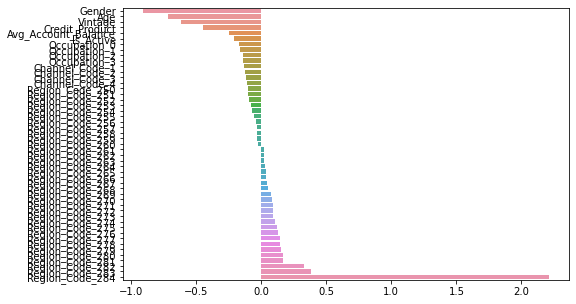

In [100]:
plt.figure(figsize=(8,5))
sns.barplot(coef,features)

<AxesSubplot:>

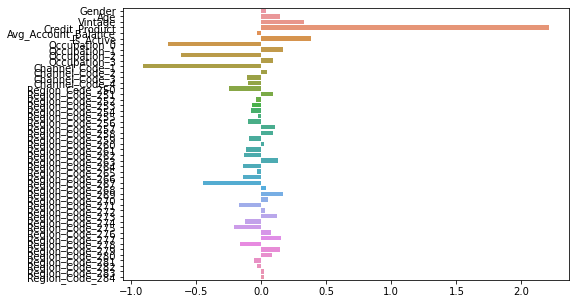

In [101]:
plt.figure(figsize=(8,5))
sns.barplot(model.coef_[0],features)

In [102]:
pred_train = model.predict(train_X)

In [103]:
print("Train Confusion matrix :\n",confusion_matrix(train_y,pred_train))
print("Accuracy Score :",accuracy_score(train_y,pred_train))
print("ROC_AUC Score :",roc_auc_score(train_y,pred_train))
print("classification report :\n",classification_report(train_y,pred_train))

Train Confusion matrix :
 [[118910  31039]
 [ 25234  78085]]
Accuracy Score : 0.7778124358387163
ROC_AUC Score : 0.7743845383677156
classification report :
               precision    recall  f1-score   support

         0.0       0.82      0.79      0.81    149949
         1.0       0.72      0.76      0.74    103319

    accuracy                           0.78    253268
   macro avg       0.77      0.77      0.77    253268
weighted avg       0.78      0.78      0.78    253268



In [104]:
pred_valid = model.predict(valid_X)

In [105]:
print("Validation Confusion matrix :\n",confusion_matrix(valid_y,pred_valid))
print("Accuracy Score :",accuracy_score(valid_y,pred_valid))
print("ROC_AUC Score :",roc_auc_score(valid_y,pred_valid))
print("classification report :\n",classification_report(valid_y,pred_valid))

Validation Confusion matrix :
 [[29542  7946]
 [ 6235 19595]]
Accuracy Score : 0.7760352506396285
ROC_AUC Score : 0.7733264269033764
classification report :
               precision    recall  f1-score   support

         0.0       0.83      0.79      0.81     37488
         1.0       0.71      0.76      0.73     25830

    accuracy                           0.78     63318
   macro avg       0.77      0.77      0.77     63318
weighted avg       0.78      0.78      0.78     63318



In [106]:
'''
submission = pd.read_csv('sample_submission_eyYijxG.csv')
final_predictions = model.predict(test)
submission['Is_Lead'] = final_predictions
#only positive predictions for the target variable
#submission['Item_Outlet_Sales'] = submission['Item_Outlet_Sales'].apply(lambda x: 0 if x<0 else x)
submission.to_csv('my_submission_LoR2.csv', index=False)
'''

"\nsubmission = pd.read_csv('sample_submission_eyYijxG.csv')\nfinal_predictions = model.predict(test)\nsubmission['Is_Lead'] = final_predictions\n#only positive predictions for the target variable\n#submission['Item_Outlet_Sales'] = submission['Item_Outlet_Sales'].apply(lambda x: 0 if x<0 else x)\nsubmission.to_csv('my_submission_LoR2.csv', index=False)\n"

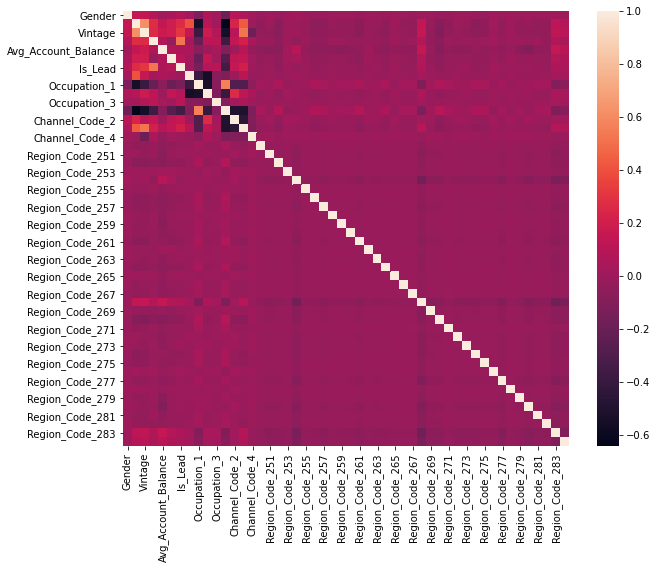

In [107]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr())
plt.show()

In [109]:
def run_model_validate(model, train_X, train_y, valid_X, valid_y):
    model.fit(train_X, train_y)
    pred_train = model.predict(train_X)
    pred_test = model.predict(valid_X)
    print(80*'*')
    print("Model Name : ",str(model).split('(')[0])
    classifier_metric_res('train',train_y, pred_train)
    score=cross_val_score(model,train_X,train_y,cv=12,scoring='accuracy')
    classifier_metric_res('valid',valid_y, pred_test)
    return model,score.mean(), accuracy_score(valid_y,pred_test), f1_score(valid_y,pred_test), roc_auc_score(valid_y,pred_test)

In [110]:
def model_predict(model,test_X,test):
    test_pred_y = model.predict(test_X)
    #submission_file_generation(model,test_X,test_pred_y,test)
    return

In [111]:
 def classifier_metric_res(train_or_test,acctual, pred):
    print(train_or_test," confusion_matrix \n", confusion_matrix(acctual, pred))
    print(train_or_test," accuracy_score     : ", accuracy_score(acctual, pred))
    print(train_or_test," recall_score       : ", recall_score(acctual, pred))
    print(train_or_test," precision_score    : ", precision_score(acctual, pred))
    print(train_or_test," f1_score           : ", f1_score(acctual, pred))
    print(train_or_test," roc_auc_score      : ", roc_auc_score(acctual, pred))
    print(train_or_test," classification report \n", classification_report(acctual, pred))
    return 

### all the below are commented to run only the RFC 
### and LGBM instead of running all the models which were executed to find the accuracy

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
RFCClassifier = RandomForestClassifier(max_features= 'auto', min_samples_split= 8, n_estimators=30)
model = [RFCClassifier]
model_name,cv_score,accuracy,f1Score,rocaucScore = run_model_validate(RFCClassifier, train_X, train_y, valid_X, valid_y)
print([str(model_name).split('(')[0],cv_score,accuracy,f1Score,rocaucScore])

********************************************************************************
Model Name :  RandomForestClassifier
train  confusion_matrix 
 [[143586   6363]
 [  5877  97442]]
train  accuracy_score     :  0.9516717469242068
train  recall_score       :  0.9431179163561397
train  precision_score    :  0.9387023746447666
train  f1_score           :  0.9409049651416543
train  roc_auc_score      :  0.95034174432536
train  classification report 
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    149949
         1.0       0.94      0.94      0.94    103319

    accuracy                           0.95    253268
   macro avg       0.95      0.95      0.95    253268
weighted avg       0.95      0.95      0.95    253268

valid  confusion_matrix 
 [[32164  5324]
 [ 3530 22300]]
valid  accuracy_score     :  0.860166145487855
valid  recall_score       :  0.8633372048006195
valid  precision_score    :  0.8072690414132638
valid  f1_score          

In [113]:
train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test.shape

((253268, 49), (253268,), (63318, 49), (63318,), (105312, 49))

In [114]:
valid_X.head()

,Gender,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Occupation_0,Occupation_1,Occupation_2,Occupation_3,...,Region_Code_275,Region_Code_276,Region_Code_277,Region_Code_278,Region_Code_279,Region_Code_280,Region_Code_281,Region_Code_282,Region_Code_283,Region_Code_284
ID,,,,,,,,,,,,,,,,,,,,,
JTKLWIAU,1,-0.083537,-0.881757,1,-0.512917,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
RERXJYBZ,1,-0.835219,-0.523243,1,-0.877692,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
DB9XSGSA,1,2.444850,0.880936,1,1.005048,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
BPQHYHPL,0,-1.381897,-0.911633,0,-0.923271,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5DN5FNHO,1,1.009820,0.163908,0,1.006220,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
 test.head()

,Gender,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Occupation_0,Occupation_1,Occupation_2,Occupation_3,...,Region_Code_275,Region_Code_276,Region_Code_277,Region_Code_278,Region_Code_279,Region_Code_280,Region_Code_281,Region_Code_282,Region_Code_283,Region_Code_284
ID,,,,,,,,,,,,,,,,,,,,,
VBENBARO,1,-0.999878,-0.676804,1,-0.452333,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCMEWNKY,1,-0.058563,0.066841,1,-0.240878,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VK3KGA9M,1,-0.865404,-1.017641,0,-1.060037,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
TT8RPZVC,1,-0.999878,-0.428922,0,-0.307219,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SHQZEYTZ,0,-0.999878,-0.862715,0,-0.550781,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:

submission = pd.read_csv('sample_submission_eyYijxG.csv')
final_predictions = RFCClassifier.predict_proba(test)[:,1]
#final_predictions = RFCClassifier.predict(test)
submission['Is_Lead'] = final_predictions
submission.to_csv('my_submission_RF2_os_pp2.csv', index=False)

In [117]:
submission["Is_Lead"].unique(), submission["Is_Lead"].value_counts()

(array([0.01388889, 0.46693723, 0.08522727, ..., 0.1473545 , 0.92301587,
        0.07228956]),
 0.000000    3198
 1.000000     786
 0.033333     496
 0.016667     363
 0.011111     356
             ... 
 0.728522       1
 0.168300       1
 0.342670       1
 0.161328       1
 0.043224       1
 Name: Is_Lead, Length: 77028, dtype: int64)

In [118]:
#!pip install lightgbm

In [119]:
from lightgbm import LGBMModel,LGBMClassifier

In [120]:
params = {'n_estimators': 10000, 'n_jobs': -1, 'random_state': 2, 
          'learning_rate': 0.014564209621859385, 'colsample_bytree': 0.48762749309989595}
lgbmodel = LGBMClassifier(**params)
lgbmodel.fit(train_X, train_y, eval_set =[(valid_X, valid_y)],  
          early_stopping_rounds=200, verbose=1000, eval_metric='auc')

pred_train = lgbmodel.predict(train_X)

print("Train Confusion matrix :\n",confusion_matrix(train_y,pred_train))
print("Accuracy Score :",accuracy_score(train_y,pred_train))
print("ROC_AUC Score :",roc_auc_score(train_y,pred_train))
print("classification report :\n",classification_report(train_y,pred_train))

pred_valid = lgbmodel.predict(valid_X)

print("Validation Confusion matrix :\n",confusion_matrix(valid_y,pred_valid))
print("Accuracy Score :",accuracy_score(valid_y,pred_valid))
print("ROC_AUC Score :",roc_auc_score(valid_y,pred_valid))
print("classification report :\n",classification_report(valid_y,pred_valid))

Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.856382	valid_0's binary_logloss: 0.457955
[2000]	valid_0's auc: 0.860208	valid_0's binary_logloss: 0.453577
[3000]	valid_0's auc: 0.86321	valid_0's binary_logloss: 0.44984
[4000]	valid_0's auc: 0.86568	valid_0's binary_logloss: 0.446604
[5000]	valid_0's auc: 0.867761	valid_0's binary_logloss: 0.443719
[6000]	valid_0's auc: 0.869769	valid_0's binary_logloss: 0.440974
[7000]	valid_0's auc: 0.87153	valid_0's binary_logloss: 0.438463
[8000]	valid_0's auc: 0.873257	valid_0's binary_logloss: 0.435983
[9000]	valid_0's auc: 0.874734	valid_0's binary_logloss: 0.433789
[10000]	valid_0's auc: 0.876083	valid_0's binary_logloss: 0.431797
Did not meet early stopping. Best iteration is:
[10000]	valid_0's auc: 0.876083	valid_0's binary_logloss: 0.431797
Train Confusion matrix :
 [[127338  22611]
 [ 22393  80926]]
Accuracy Score : 0.8223068054392975
ROC_AUC Score : 0.8162361079517682
classification report :
          

In [121]:
submission = pd.read_csv('sample_submission_eyYijxG.csv')
final_predictions = lgbmodel.predict_proba(test)[:,1]
submission['Is_Lead'] = final_predictions
submission.to_csv('my_submission_lgb_os_pp2.csv', index=False)

In [122]:
submission["Is_Lead"].unique(), submission["Is_Lead"].value_counts()

(array([0.09080471, 0.49695205, 0.05690124, ..., 0.12688264, 0.32022971,
        0.13809187]),
 0.096099    3
 0.072262    3
 0.109057    3
 0.069311    3
 0.045021    3
            ..
 0.081472    1
 0.738618    1
 0.788883    1
 0.078090    1
 0.060159    1
 Name: Is_Lead, Length: 104714, dtype: int64)